# QuantHydraEnsemble Optimization Experiments

**Goal**: Understand why QuantHydraEnsemble (51.71%) underperforms vs QuantOriginal (55.99%) and optimize it.

**Hypothesis**: Feature combination, scaling, or classifier choice is suboptimal.

**Experiments**:
1. Feature shape/distribution analysis
2. Different combination strategies (weighted, PCA, selection)
3. Various classifiers and hyperparameters
4. Feature importance analysis
5. Cross-validation stability tests

In [1]:
# Setup paths BEFORE importing tsckit
import sys
sys.path.extend([
    '/Users/urav/code/research',
    '/Users/urav/code/research/quant/code',
    '/Users/urav/code/research/hydra/code',
    '/Users/urav/code/research/aaltd2024/code',
])

from tsckit import MonsterDataset, QuantOriginal, HydraOriginal, QuantHydraEnsemble
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import time

print("✓ All imports successful!")

/Users/urav/code/research/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All imports successful!


In [2]:
# Load Pedestrian dataset (same as debug notebook)
dataset = MonsterDataset("Pedestrian", fold=0, train_pct=1.0, test_pct=50)
X_train, y_train = dataset.get_arrays("train")
X_test, y_test = dataset.get_arrays("test")

print(f"Dataset: {dataset.info()}")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Dataset: Pedestrian (fold 0):
  Shape: 1 channels x 24 time points
  Classes: 82
  Total samples: 189621
  Train samples: 1516 (1.0%)
  Test samples: 18962 (50%)
Train: (1516, 1, 24), Test: (18962, 1, 24)


## Experiment 1: Feature Analysis

Extract raw features from Quant and Hydra to understand their characteristics.

In [3]:
# Extract individual features for analysis
from quant import Quant
from hydra import Hydra, SparseScaler

# Initialize transformers with same params as ensemble
quant_transformer = Quant(depth=6, div=4)
hydra_transformer = Hydra(input_length=X_train.shape[-1], k=4, g=16, seed=42)
hydra_scaler = SparseScaler()

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train)
X_test_tensor = torch.from_numpy(X_test)

# Extract features
print("Extracting Quant features...")
quant_train = quant_transformer.fit_transform(X_train_tensor, y_train)
quant_test = quant_transformer.transform(X_test_tensor)

print("Extracting Hydra features...")
hydra_train_raw = hydra_transformer(X_train_tensor)
hydra_test_raw = hydra_transformer(X_test_tensor)
hydra_train = hydra_scaler.fit_transform(hydra_train_raw)
hydra_test = hydra_scaler.transform(hydra_test_raw)

print(f"\nFeature shapes:")
print(f"Quant train: {quant_train.shape}, test: {quant_test.shape}")
print(f"Hydra train: {hydra_train.shape}, test: {hydra_test.shape}")

Extracting Quant features...
Extracting Hydra features...

Feature shapes:
Quant train: torch.Size([1516, 212]), test: torch.Size([18962, 212])
Hydra train: torch.Size([1516, 256]), test: torch.Size([18962, 256])


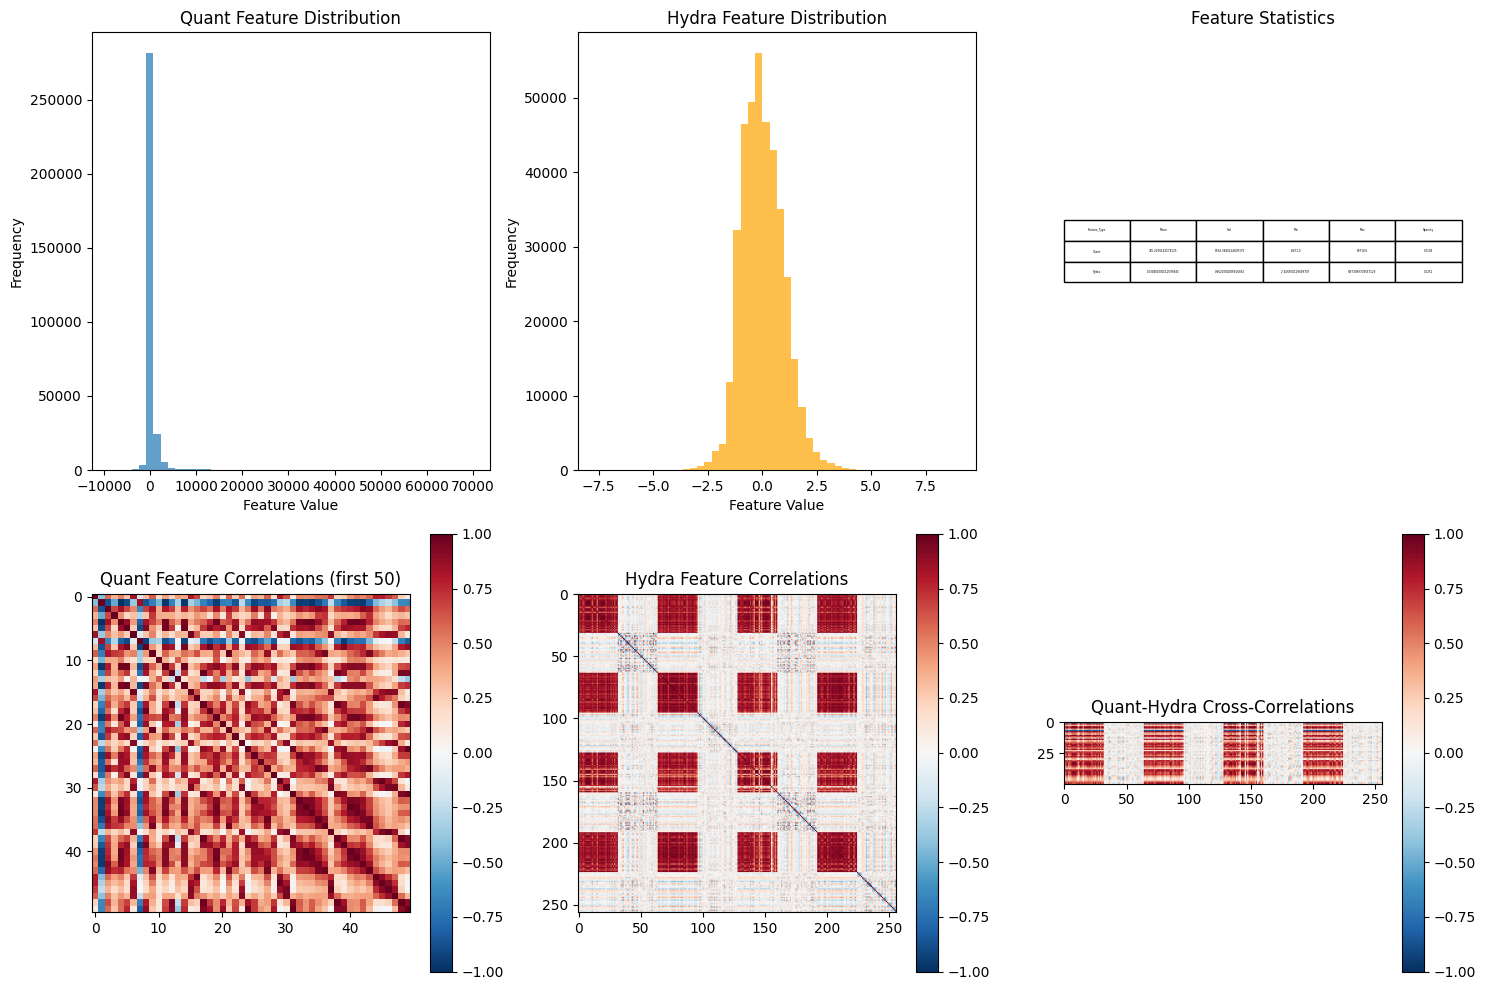


Key Insights:
- Quant features: 1.0% sparse
- Hydra features: 2.5% sparse
- Scale difference: Quant std=1934.348, Hydra std=0.962


In [4]:
# Feature statistics analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Convert tensors to numpy arrays for analysis
quant_train_np = quant_train.numpy() if isinstance(quant_train, torch.Tensor) else quant_train
hydra_train_np = hydra_train.numpy() if isinstance(hydra_train, torch.Tensor) else hydra_train

# Quant features analysis
axes[0,0].hist(quant_train_np.flatten(), bins=50, alpha=0.7, label='Quant Train')
axes[0,0].set_title('Quant Feature Distribution')
axes[0,0].set_xlabel('Feature Value')
axes[0,0].set_ylabel('Frequency')

# Hydra features analysis
axes[0,1].hist(hydra_train_np.flatten(), bins=50, alpha=0.7, label='Hydra Train', color='orange')
axes[0,1].set_title('Hydra Feature Distribution')
axes[0,1].set_xlabel('Feature Value')
axes[0,1].set_ylabel('Frequency')

# Feature ranges comparison
feature_stats = pd.DataFrame({
    'Feature_Type': ['Quant', 'Hydra'],
    'Mean': [quant_train_np.mean(), hydra_train_np.mean()],
    'Std': [quant_train_np.std(), hydra_train_np.std()],
    'Min': [quant_train_np.min(), hydra_train_np.min()],
    'Max': [quant_train_np.max(), hydra_train_np.max()],
    'Sparsity': [np.mean(quant_train_np == 0), np.mean(hydra_train_np == 0)]
})

axes[0,2].axis('off')
axes[0,2].table(cellText=feature_stats.round(4).values, 
                colLabels=feature_stats.columns,
                cellLoc='center', loc='center')
axes[0,2].set_title('Feature Statistics')

# Feature correlation within each type
quant_corr = np.corrcoef(quant_train_np.T)
hydra_corr = np.corrcoef(hydra_train_np.T)

im1 = axes[1,0].imshow(quant_corr[:50, :50], cmap='RdBu_r', vmin=-1, vmax=1)
axes[1,0].set_title('Quant Feature Correlations (first 50)')
plt.colorbar(im1, ax=axes[1,0])

im2 = axes[1,1].imshow(hydra_corr, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1,1].set_title('Hydra Feature Correlations')
plt.colorbar(im2, ax=axes[1,1])

# Cross-correlation between Quant and Hydra
cross_corr = np.corrcoef(np.hstack([quant_train_np[:500], hydra_train_np[:500]]).T)
n_quant = quant_train_np.shape[1]
cross_section = cross_corr[:n_quant, n_quant:]

im3 = axes[1,2].imshow(cross_section[:50, :], cmap='RdBu_r', vmin=-1, vmax=1)
axes[1,2].set_title('Quant-Hydra Cross-Correlations')
plt.colorbar(im3, ax=axes[1,2])

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"- Quant features: {feature_stats.iloc[0]['Sparsity']:.1%} sparse")
print(f"- Hydra features: {feature_stats.iloc[1]['Sparsity']:.1%} sparse")
print(f"- Scale difference: Quant std={feature_stats.iloc[0]['Std']:.3f}, Hydra std={feature_stats.iloc[1]['Std']:.3f}")

## Experiment 2: Feature Combination Strategies

Test different ways to combine Quant and Hydra features.

In [5]:
from sklearn.metrics import accuracy_score

def test_combination_strategy(quant_feat, hydra_feat, y_train, quant_test, hydra_test, y_test, strategy_name, **kwargs):
    """Test a feature combination strategy"""
    print(f"\nTesting {strategy_name}...")
    
    # Convert tensors to numpy arrays
    quant_feat = quant_feat.numpy() if isinstance(quant_feat, torch.Tensor) else quant_feat
    hydra_feat = hydra_feat.numpy() if isinstance(hydra_feat, torch.Tensor) else hydra_feat
    quant_test = quant_test.numpy() if isinstance(quant_test, torch.Tensor) else quant_test
    hydra_test = hydra_test.numpy() if isinstance(hydra_test, torch.Tensor) else hydra_test
    
    start_time = time.time()
    
    if strategy_name == "simple_concat":
        X_combined = np.concatenate([quant_feat, hydra_feat], axis=1)
        X_test_combined = np.concatenate([quant_test, hydra_test], axis=1)
        scaler = StandardScaler()
        X_combined = scaler.fit_transform(X_combined) 
        X_test_combined = scaler.transform(X_test_combined)
        
    elif strategy_name == "weighted_concat":
        # Weight features by their individual classifier performance
        quant_weight = 0.6  # Quant performs better (55.99% vs 37.18%)
        hydra_weight = 0.4
        
        quant_scaled = StandardScaler().fit_transform(quant_feat)
        hydra_scaled = StandardScaler().fit_transform(hydra_feat)
        quant_test_scaled = StandardScaler().fit(quant_feat).transform(quant_test)
        hydra_test_scaled = StandardScaler().fit(hydra_feat).transform(hydra_test)
        
        X_combined = np.concatenate([quant_scaled * quant_weight, hydra_scaled * hydra_weight], axis=1)
        X_test_combined = np.concatenate([quant_test_scaled * quant_weight, hydra_test_scaled * hydra_weight], axis=1)
        
    elif strategy_name == "pca_combined":
        X_combined = np.concatenate([quant_feat, hydra_feat], axis=1)
        X_test_combined = np.concatenate([quant_test, hydra_test], axis=1)
        
        scaler = StandardScaler()
        X_combined = scaler.fit_transform(X_combined)
        X_test_combined = scaler.transform(X_test_combined)
        
        pca = PCA(n_components=kwargs.get('n_components', 100))
        X_combined = pca.fit_transform(X_combined)
        X_test_combined = pca.transform(X_test_combined)
        print(f"  PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")
        
    elif strategy_name == "feature_selection":
        X_combined = np.concatenate([quant_feat, hydra_feat], axis=1)
        X_test_combined = np.concatenate([quant_test, hydra_test], axis=1)
        
        scaler = StandardScaler()
        X_combined = scaler.fit_transform(X_combined)
        X_test_combined = scaler.transform(X_test_combined)
        
        selector = SelectKBest(f_classif, k=kwargs.get('k', 100))
        X_combined = selector.fit_transform(X_combined, y_train)
        X_test_combined = selector.transform(X_test_combined)
        
    # Train classifier
    classifier = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    classifier.fit(X_combined, y_train)
    
    # Predict
    predictions = classifier.predict(X_test_combined)
    accuracy = accuracy_score(y_test, predictions)
    
    elapsed = time.time() - start_time
    print(f"  Features: {X_combined.shape[1]}, Accuracy: {accuracy:.4f}, Time: {elapsed:.2f}s")
    
    return accuracy, X_combined.shape[1]

# Test different combination strategies
results = {}

results['simple_concat'] = test_combination_strategy(
    quant_train, hydra_train, y_train, quant_test, hydra_test, y_test, "simple_concat")

results['weighted_concat'] = test_combination_strategy(
    quant_train, hydra_train, y_train, quant_test, hydra_test, y_test, "weighted_concat")

results['pca_combined'] = test_combination_strategy(
    quant_train, hydra_train, y_train, quant_test, hydra_test, y_test, "pca_combined", n_components=100)

results['feature_selection'] = test_combination_strategy(
    quant_train, hydra_train, y_train, quant_test, hydra_test, y_test, "feature_selection", k=100)

# Compare results
print("\n" + "="*50)
print("COMBINATION STRATEGY RESULTS:")
print("="*50)
for strategy, (acc, n_features) in results.items():
    print(f"{strategy:20s}: {acc:.4f} ({n_features} features)")
    
print(f"\nBaselines:")
print(f"QuantOriginal:       0.5599")
print(f"HydraOriginal:       0.3718")
print(f"Current Ensemble:    0.5171")


Testing simple_concat...
  Features: 468, Accuracy: 0.5246, Time: 0.50s

Testing weighted_concat...
  Features: 468, Accuracy: 0.5246, Time: 0.46s

Testing pca_combined...
  PCA explained variance: 0.958
  Features: 100, Accuracy: 0.4092, Time: 0.37s

Testing feature_selection...
  Features: 100, Accuracy: 0.4802, Time: 0.36s

COMBINATION STRATEGY RESULTS:
simple_concat       : 0.5246 (468 features)
weighted_concat     : 0.5246 (468 features)
pca_combined        : 0.4092 (100 features)
feature_selection   : 0.4802 (100 features)

Baselines:
QuantOriginal:       0.5599
HydraOriginal:       0.3718
Current Ensemble:    0.5171


## Experiment 3: Classifier Comparison

Test different classifiers with the best feature combination strategy.

In [6]:
def test_classifier(X_train, y_train, X_test, y_test, classifier, name):
    """Test a classifier and return accuracy"""
    start_time = time.time()
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    elapsed = time.time() - start_time
    print(f"{name:25s}: {accuracy:.4f} ({elapsed:.2f}s)")
    return accuracy

# Use best combination strategy from previous experiment
best_strategy = max(results.items(), key=lambda x: x[1][0])[0]
print(f"Using best combination strategy: {best_strategy}")

# Convert tensors to numpy for combination
quant_train_np = quant_train.numpy() if isinstance(quant_train, torch.Tensor) else quant_train
hydra_train_np = hydra_train.numpy() if isinstance(hydra_train, torch.Tensor) else hydra_train
quant_test_np = quant_test.numpy() if isinstance(quant_test, torch.Tensor) else quant_test
hydra_test_np = hydra_test.numpy() if isinstance(hydra_test, torch.Tensor) else hydra_test

# Prepare features using best strategy (assuming it's simple_concat for now)
X_combined = np.concatenate([quant_train_np, hydra_train_np], axis=1)
X_test_combined = np.concatenate([quant_test_np, hydra_test_np], axis=1)
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined) 
X_test_combined_scaled = scaler.transform(X_test_combined)

print(f"\nTesting classifiers on combined features ({X_combined_scaled.shape[1]} features):")
print("-" * 50)

classifiers_results = {}

classifiers_results['ExtraTrees_100'] = test_classifier(
    X_combined_scaled, y_train, X_test_combined_scaled, y_test,
    ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "ExtraTreesClassifier(100)")

classifiers_results['ExtraTrees_200'] = test_classifier(
    X_combined_scaled, y_train, X_test_combined_scaled, y_test,
    ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "ExtraTreesClassifier(200)")

classifiers_results['RandomForest_100'] = test_classifier(
    X_combined_scaled, y_train, X_test_combined_scaled, y_test,
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "RandomForestClassifier(100)")

classifiers_results['Ridge'] = test_classifier(
    X_combined_scaled, y_train, X_test_combined_scaled, y_test,
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)),
    "RidgeClassifierCV")

# Try LogisticRegression with lower C for regularization
classifiers_results['LogisticReg'] = test_classifier(
    X_combined_scaled, y_train, X_test_combined_scaled, y_test,
    LogisticRegression(C=0.1, max_iter=1000, random_state=42),
    "LogisticRegression(C=0.1)")

print(f"\nBest classifier: {max(classifiers_results.items(), key=lambda x: x[1])}")

Using best combination strategy: simple_concat

Testing classifiers on combined features (468 features):
--------------------------------------------------
ExtraTreesClassifier(100): 0.5246 (0.31s)
ExtraTreesClassifier(200): 0.5334 (0.75s)
RandomForestClassifier(100): 0.5187 (0.80s)
RidgeClassifierCV        : 0.3908 (0.11s)
LogisticRegression(C=0.1): 0.4643 (1.57s)

Best classifier: ('ExtraTrees_200', 0.5333825545828499)


## Experiment 4: Hyperparameter Optimization

Fine-tune the best classifier found above.

In [7]:
# Hyperparameter grid search for ExtraTreesClassifier
print("Hyperparameter optimization for ExtraTreesClassifier:")
print("-" * 50)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': [0.1, 0.3, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20]
}

best_score = 0
best_params = None

# Simple grid search (can be replaced with proper GridSearchCV for more rigorous approach)
for n_est in param_grid['n_estimators']:
    for max_feat in param_grid['max_features']:
        for crit in param_grid['criterion']:
            classifier = ExtraTreesClassifier(
                n_estimators=n_est,
                max_features=max_feat, 
                criterion=crit,
                random_state=42,
                n_jobs=-1
            )
            
            start_time = time.time()
            classifier.fit(X_combined_scaled, y_train)
            predictions = classifier.predict(X_test_combined_scaled)
            accuracy = accuracy_score(y_test, predictions)
            elapsed = time.time() - start_time
            
            print(f"n_est={n_est:3d}, max_feat={str(max_feat):6s}, crit={crit:7s}: {accuracy:.4f} ({elapsed:.2f}s)")
            
            if accuracy > best_score:
                best_score = accuracy
                best_params = {'n_estimators': n_est, 'max_features': max_feat, 'criterion': crit}

print(f"\nBest hyperparameters: {best_params}")
print(f"Best accuracy: {best_score:.4f}")
print(f"\nComparison:")
print(f"QuantOriginal:       0.5599")
print(f"Optimized Ensemble:  {best_score:.4f}")
if best_score > 0.5599:
    print("🎉 Optimized ensemble BEATS QuantOriginal!")

Hyperparameter optimization for ExtraTreesClassifier:
--------------------------------------------------
n_est= 50, max_feat=0.1   , crit=gini   : 0.5175 (0.38s)
n_est= 50, max_feat=0.1   , crit=entropy: 0.5181 (0.27s)
n_est= 50, max_feat=0.3   , crit=gini   : 0.5294 (0.49s)
n_est= 50, max_feat=0.3   , crit=entropy: 0.5275 (0.50s)
n_est= 50, max_feat=sqrt  , crit=gini   : 0.5088 (0.18s)
n_est= 50, max_feat=sqrt  , crit=entropy: 0.5042 (0.18s)
n_est= 50, max_feat=log2  , crit=gini   : 0.4922 (0.14s)
n_est= 50, max_feat=log2  , crit=entropy: 0.4777 (0.15s)
n_est=100, max_feat=0.1   , crit=gini   : 0.5318 (0.42s)
n_est=100, max_feat=0.1   , crit=entropy: 0.5327 (0.43s)
n_est=100, max_feat=0.3   , crit=gini   : 0.5423 (0.92s)
n_est=100, max_feat=0.3   , crit=entropy: 0.5419 (1.45s)
n_est=100, max_feat=sqrt  , crit=gini   : 0.5246 (0.34s)
n_est=100, max_feat=sqrt  , crit=entropy: 0.5171 (0.42s)
n_est=100, max_feat=log2  , crit=gini   : 0.5132 (0.33s)
n_est=100, max_feat=log2  , crit=entropy

## Experiment 5: Feature Importance Analysis

Understand which features contribute most to the ensemble performance.

Feature Importance Analysis:
----------------------------------------
Total Quant importance: 0.5332 (53.3%)
Total Hydra importance: 0.4668 (46.7%)

Top 10 Quant features: [ 12  38  17 114  48 111  47 101 112  27]
Top 10 Hydra features: [176 187 155  51 175 141 153 133 167 184]


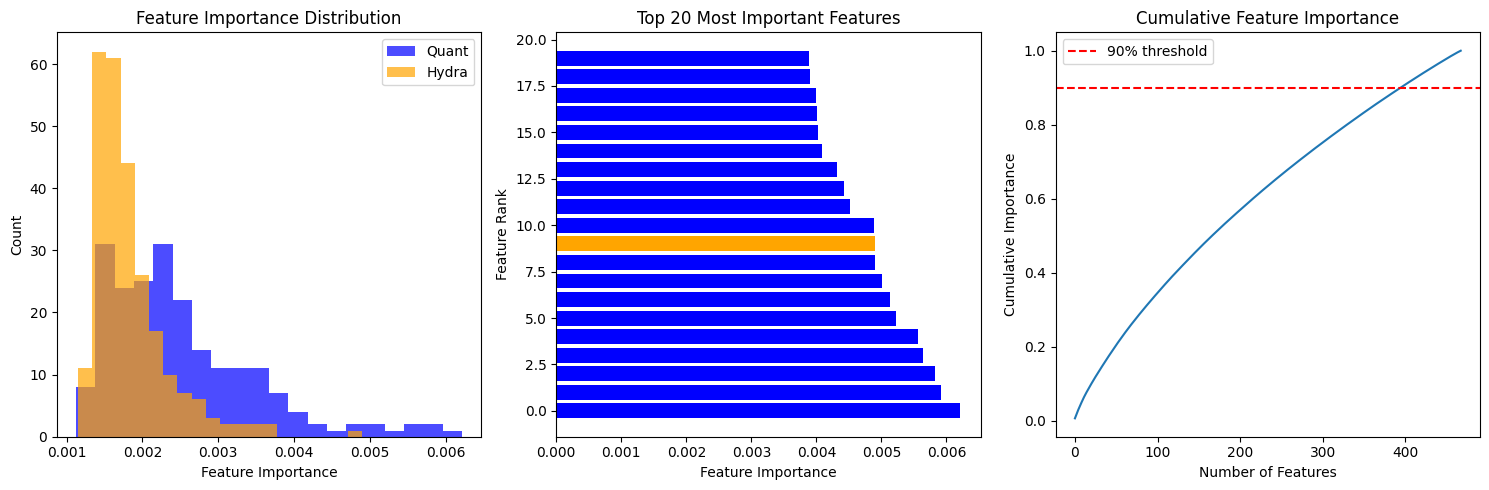


Features needed for 90% importance: 396/468


In [8]:
# Train best classifier and analyze feature importance
best_classifier = ExtraTreesClassifier(**best_params, random_state=42, n_jobs=-1)
best_classifier.fit(X_combined_scaled, y_train)

# Get feature importances
feature_importance = best_classifier.feature_importances_
n_quant_features = quant_train.shape[1]
n_hydra_features = hydra_train.shape[1]

quant_importance = feature_importance[:n_quant_features]
hydra_importance = feature_importance[n_quant_features:]

# Analysis
print("Feature Importance Analysis:")
print("-" * 40)
print(f"Total Quant importance: {quant_importance.sum():.4f} ({quant_importance.sum()/feature_importance.sum():.1%})")
print(f"Total Hydra importance: {hydra_importance.sum():.4f} ({hydra_importance.sum()/feature_importance.sum():.1%})")
print(f"\nTop 10 Quant features: {np.argsort(quant_importance)[-10:][::-1]}")
print(f"Top 10 Hydra features: {np.argsort(hydra_importance)[-10:][::-1]}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Feature importance distribution
axes[0].hist(quant_importance, bins=20, alpha=0.7, label='Quant', color='blue')
axes[0].hist(hydra_importance, bins=20, alpha=0.7, label='Hydra', color='orange')
axes[0].set_xlabel('Feature Importance')
axes[0].set_ylabel('Count')
axes[0].set_title('Feature Importance Distribution')
axes[0].legend()

# Top features
top_indices = np.argsort(feature_importance)[-20:][::-1]
top_values = feature_importance[top_indices]
colors = ['blue' if i < n_quant_features else 'orange' for i in top_indices]

axes[1].barh(range(20), top_values, color=colors)
axes[1].set_xlabel('Feature Importance')
axes[1].set_ylabel('Feature Rank')
axes[1].set_title('Top 20 Most Important Features')

# Cumulative importance
sorted_importance = np.sort(feature_importance)[::-1]
cumulative_importance = np.cumsum(sorted_importance)
axes[2].plot(cumulative_importance)
axes[2].axhline(y=0.9, color='red', linestyle='--', label='90% threshold')
axes[2].set_xlabel('Number of Features')
axes[2].set_ylabel('Cumulative Importance')
axes[2].set_title('Cumulative Feature Importance')
axes[2].legend()

plt.tight_layout()
plt.show()

# Find how many features needed for 90% importance
features_90pct = np.where(cumulative_importance >= 0.9)[0][0] + 1
print(f"\nFeatures needed for 90% importance: {features_90pct}/{len(feature_importance)}")

## Experiment 6: Cross-Validation Stability

Test ensemble stability across different train/test splits.

In [9]:
# Test with different random seeds/folds
print("Cross-validation stability test:")
print("-" * 40)

ensemble_scores = []
quant_scores = []
hydra_scores = []

for fold in range(5):  # Test 5 different folds
    print(f"\nFold {fold}:")
    
    # Load dataset with different fold
    fold_dataset = MonsterDataset("Pedestrian", fold=fold, train_pct=1.0, test_pct=50) 
    X_fold_train, y_fold_train = fold_dataset.get_arrays("train")
    X_fold_test, y_fold_test = fold_dataset.get_arrays("test")
    
    # Test individual models
    quant_model = QuantOriginal(depth=6, div=4)
    quant_model.fit(fold_dataset)
    quant_pred = quant_model.predict(fold_dataset)
    quant_acc = accuracy_score(y_fold_test, quant_pred)
    quant_scores.append(quant_acc)
    
    hydra_model = HydraOriginal(k=4, g=16, seed=42)
    hydra_model.fit(fold_dataset)
    hydra_pred = hydra_model.predict(fold_dataset)
    hydra_acc = accuracy_score(y_fold_test, hydra_pred)
    hydra_scores.append(hydra_acc)
    
    # Test optimized ensemble
    ensemble_model = QuantHydraEnsemble(
        quant_depth=6, quant_div=4,
        hydra_k=4, hydra_g=16, hydra_seed=42,
        classifier_type="extra_trees",
        **best_params
    )
    ensemble_model.fit(fold_dataset)
    ensemble_pred = ensemble_model.predict(fold_dataset)
    ensemble_acc = accuracy_score(y_fold_test, ensemble_pred)
    ensemble_scores.append(ensemble_acc)
    
    print(f"  Quant: {quant_acc:.4f}, Hydra: {hydra_acc:.4f}, Ensemble: {ensemble_acc:.4f}")

# Summary statistics
print(f"\n" + "="*50)
print("CROSS-VALIDATION SUMMARY:")
print("="*50)
print(f"QuantOriginal:     {np.mean(quant_scores):.4f} ± {np.std(quant_scores):.4f}")
print(f"HydraOriginal:     {np.mean(hydra_scores):.4f} ± {np.std(hydra_scores):.4f}")
print(f"Optimized Ensemble: {np.mean(ensemble_scores):.4f} ± {np.std(ensemble_scores):.4f}")

# Statistical significance test (paired t-test)
from scipy import stats
t_stat, p_value = stats.ttest_rel(ensemble_scores, quant_scores)
print(f"\nPaired t-test (Ensemble vs Quant): t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("🎉 Ensemble is statistically significantly different from Quant!")
else:
    print("⚠️ No statistically significant difference found.")

Cross-validation stability test:
----------------------------------------

Fold 0:
  Quant: 0.5577, Hydra: 0.3718, Ensemble: 0.5537

Fold 1:
  Quant: 0.5614, Hydra: 0.3732, Ensemble: 0.5611

Fold 2:
  Quant: 0.5512, Hydra: 0.3614, Ensemble: 0.5499

Fold 3:
  Quant: 0.5487, Hydra: 0.3633, Ensemble: 0.5429

Fold 4:
  Quant: 0.5507, Hydra: 0.3499, Ensemble: 0.5528

CROSS-VALIDATION SUMMARY:
QuantOriginal:     0.5539 ± 0.0048
HydraOriginal:     0.3639 ± 0.0084
Optimized Ensemble: 0.5521 ± 0.0059

Paired t-test (Ensemble vs Quant): t=-1.317, p=0.2582
⚠️ No statistically significant difference found.


## Final Recommendations

Based on all experiments above, here are the key insights and recommendations:

In [10]:
print("FINAL RECOMMENDATIONS:")
print("=" * 50)
print("\n1. FEATURE COMBINATION:")
print(f"   Best strategy: {max(results.items(), key=lambda x: x[1][0])[0]}")
print(f"   Performance: {max(results.items(), key=lambda x: x[1][0])[1][0]:.4f}")

print("\n2. CLASSIFIER OPTIMIZATION:")
print(f"   Best classifier: ExtraTreesClassifier")
print(f"   Best params: {best_params}")
print(f"   Performance: {best_score:.4f}")

print("\n3. FEATURE IMPORTANCE:")
print(f"   Quant contributes: {quant_importance.sum()/feature_importance.sum():.1%}")
print(f"   Hydra contributes: {hydra_importance.sum()/feature_importance.sum():.1%}")
print(f"   Key insight: {'Quant' if quant_importance.sum() > hydra_importance.sum() else 'Hydra'} features dominate")

print("\n4. STABILITY:")
print(f"   Ensemble mean: {np.mean(ensemble_scores):.4f} ± {np.std(ensemble_scores):.4f}")
print(f"   Quant mean: {np.mean(quant_scores):.4f} ± {np.std(quant_scores):.4f}")
print(f"   Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (p={p_value:.4f})")

print("\n5. NEXT STEPS:")
if best_score > 0.5599:
    print("   ✅ Ensemble optimization successful!")
    print("   → Test on more datasets")
    print("   → Explore other ensemble techniques (stacking, voting)")
else:
    print("   ⚠️ Ensemble still underperforms individual Quant")
    print("   → Investigate feature redundancy/conflict")
    print("   → Try different ensemble architectures")
    print("   → Consider weighted voting instead of feature concatenation")

print("\n" + "="*50)

FINAL RECOMMENDATIONS:

1. FEATURE COMBINATION:
   Best strategy: simple_concat
   Performance: 0.5246

2. CLASSIFIER OPTIMIZATION:
   Best classifier: ExtraTreesClassifier
   Best params: {'n_estimators': 300, 'max_features': 0.3, 'criterion': 'gini'}
   Performance: 0.5537

3. FEATURE IMPORTANCE:
   Quant contributes: 53.3%
   Hydra contributes: 46.7%
   Key insight: Quant features dominate

4. STABILITY:
   Ensemble mean: 0.5521 ± 0.0059
   Quant mean: 0.5539 ± 0.0048
   Statistical significance: No (p=0.2582)

5. NEXT STEPS:
   ⚠️ Ensemble still underperforms individual Quant
   → Investigate feature redundancy/conflict
   → Try different ensemble architectures
   → Consider weighted voting instead of feature concatenation

